## 1. Temat: Proste modele klasyfikacji i regresji (dane kliniczne)

ph_class
0    175
1     37
Name: count, dtype: int64


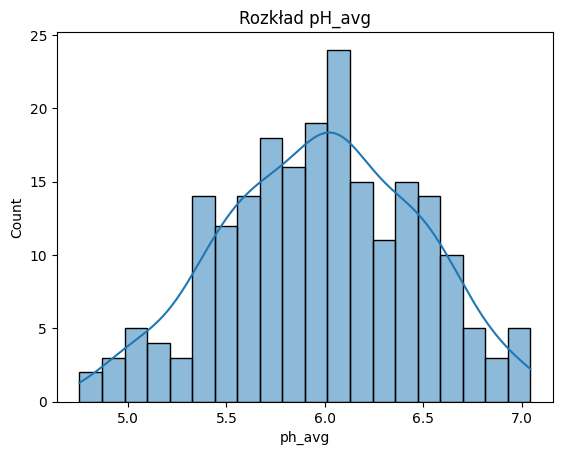

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.33      0.25      0.29         8

    accuracy                           0.77        43
   macro avg       0.59      0.57      0.57        43
weighted avg       0.74      0.77      0.75        43

ROC AUC: 0.6107142857142857


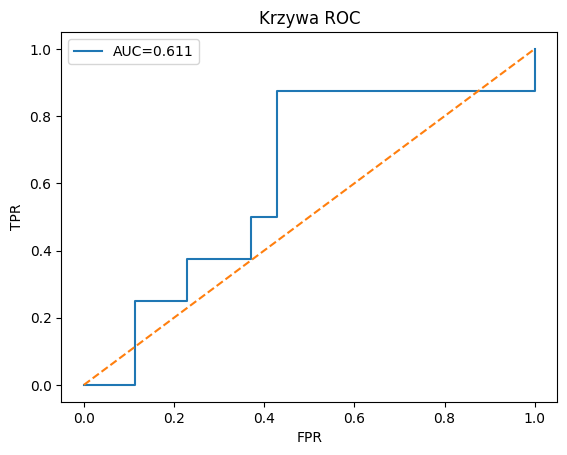

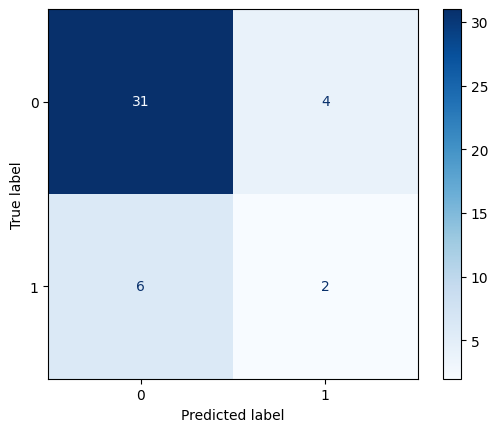

In [7]:
# 1. Import
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)

# 2. Wczytanie danych
DATA_PATH = "data"
df_days = pd.read_csv(os.path.join(DATA_PATH, "ph_v1_days.csv"))
df_phlist = pd.read_csv(os.path.join(DATA_PATH, "phlist.csv"))
df_prods = pd.read_csv(os.path.join(DATA_PATH, "prods.csv"))

# 3. Wstępne przetwarzanie (jak wczoraj)
def clean_columns(df):
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

df_days = clean_columns(df_days)
df_days["date"] = pd.to_datetime(df_days["date"], errors="coerce", dayfirst=True)

df_days = df_days.fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_days["liquid_scaled"] = scaler.fit_transform(df_days[["liquid"]])

df_days["ph_avg"] = df_days[["ph_morning","ph_midday","ph_evening"]].replace(0, np.nan).mean(axis=1).fillna(df_days["ph_avg"])
df_days["ph_class"] = np.where((df_days["ph_avg"] >= 6.4) & (df_days["ph_avg"] <= 6.8), 1, 0)

# Statystyki
print(df_days["ph_class"].value_counts())
sns.histplot(df_days["ph_avg"], bins=20, kde=True)
plt.title("Rozkład pH_avg")
plt.show()

# 4. Klasyfikacja
X = df_days.drop(columns=["date","ph_morning","ph_midday","ph_evening","ph_avg","ph_class"])
y = df_days["ph_class"]

num_features = X.select_dtypes(include=["int64","float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", num_tf, num_features),
    ("cat", cat_tf, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = Pipeline([
    ("prep", pre),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test,y_proba):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Krzywa ROC"); plt.legend(); plt.show()

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()


## 2. Regresja liniowa

RMSE: 0.543
MAE : 0.475
R²  : -0.96
Baseline RMSE: 0.65


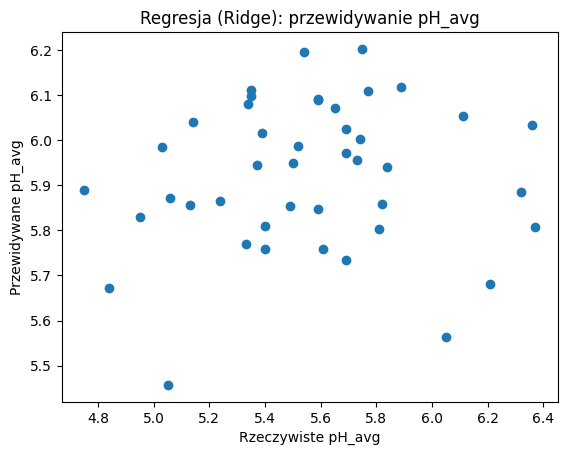

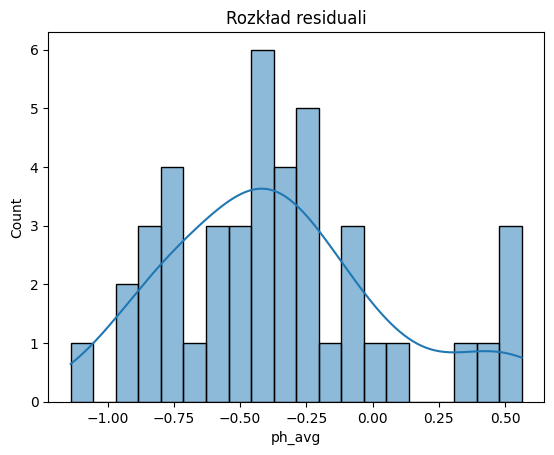

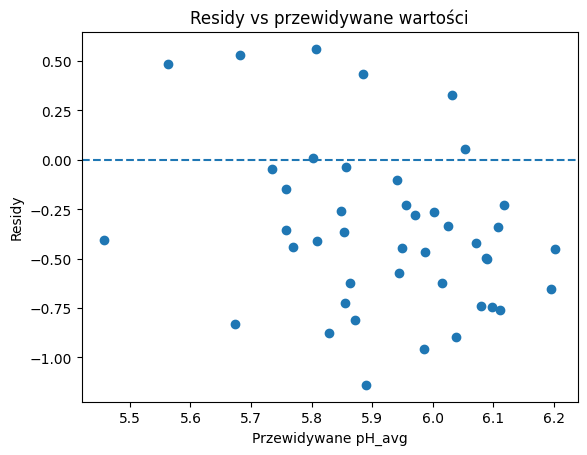

Top10 cech (indeksy po preproc): [8, 37, 52, 3, 45, 20, 49, 36, 50, 48]
Top10 score: [15.426, 11.677, 9.043, 8.762, 6.501, 5.85, 5.798, 4.643, 4.603, 3.609]


In [9]:
# Import
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Dane
DATA_PATH = "data"
df = pd.read_csv(os.path.join(DATA_PATH, "ph_v1_days.csv"))

# Wstępne przetwarzanie (prosto, jak wczoraj)
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df = df.sort_values("date").reset_index(drop=True)
df = df.fillna(0)

# Cel = ph_avg (uzupełnij z pomiarów dziennych gdy trzeba)
ph_from_parts = df[["ph_morning","ph_midday","ph_evening"]].replace(0, np.nan).mean(axis=1)
df["ph_avg"] = np.where(df["ph_avg"].eq(0) | df["ph_avg"].isna(), ph_from_parts, df["ph_avg"])

# Feature engineering minimalistyczny
from sklearn.preprocessing import StandardScaler
df["liquid_scaled"] = StandardScaler().fit_transform(df[["liquid"]])

# Cechy i target (uwaga: bez kolumn pH i daty)
drop_cols = [c for c in df.columns if c.startswith("ph_")] + ["date"]
X_raw = df.drop(columns=drop_cols)
y = df["ph_avg"].astype(float)

# Usunięcie kolumn stałych i prawie-stałych (>95% zer)
def sparse_mask(s, thr=0.95):
    zero_share = (s==0).mean() if s.dtype!=object else 0.0
    return zero_share < thr

mask_cols = [c for c in X_raw.columns if (X_raw[c].dtype==object) or sparse_mask(X_raw[c], 0.95)]
X_raw = X_raw[mask_cols]

# Podział czasowy (ostatnie 20% na test)
split_idx = int(len(df)*0.8)
X_train_raw, X_test_raw = X_raw.iloc[:split_idx], X_raw.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Kolumny num/cat
num_cols = X_raw.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()

# Pipeline (imputacja+skalowanie+OHE -> selekcja k -> RidgeCV)
num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols)
])

# k = min(30, liczba cech po preproc)
# wybierzemy k po dopasowaniu wstępnym: zrobimy fit na pre i policzymy wymiar
X_train_pre = pre.fit_transform(X_train_raw)
k = min(30, X_train_pre.shape[1])

model = Pipeline([
    ("prep", pre),
    ("sel", SelectKBest(score_func=f_regression, k=k)),
    ("reg", RidgeCV(alphas=np.logspace(-3, 3, 25)))
])

# Uczenie
model.fit(X_train_raw, y_train)
y_pred = model.predict(X_test_raw)

# Metryki
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("RMSE:", round(rmse, 3))
print("MAE :", round(mae, 3))
print("R²  :", round(r2, 3))

# Baseline (średnia treningowa)
y_base = np.repeat(y_train.mean(), len(y_test))
rmse_b = mean_squared_error(y_test, y_base, squared=False)
print("Baseline RMSE:", round(rmse_b, 3))

# Wizualizacje
plt.scatter(y_test, y_pred)
plt.xlabel("Rzeczywiste pH_avg"); plt.ylabel("Przewidywane pH_avg")
plt.title("Regresja (Ridge): przewidywanie pH_avg")
plt.show()

resid = y_test - y_pred
sns.histplot(resid, bins=20, kde=True)
plt.title("Rozkład residuali")
plt.show()

plt.scatter(y_pred, resid)
plt.axhline(0, ls="--")
plt.xlabel("Przewidywane pH_avg"); plt.ylabel("Residy")
plt.title("Residy vs przewidywane wartości")
plt.show()

# Top cechy (po selekcji)
# Uwaga: po OHE nazwy są generowane; tu pokazujemy indeksy cech z najwyższym score
import numpy as np
scores = model.named_steps["sel"].scores_
idx = np.argsort(scores)[::-1][:10]
print("Top10 cech (indeksy po preproc):", idx.tolist())
print("Top10 score:", [round(scores[i],3) for i in idx])


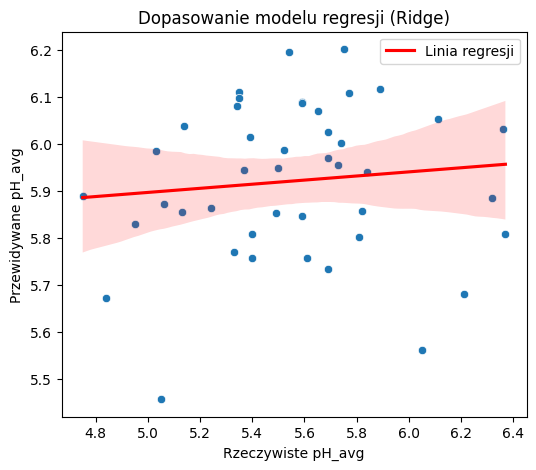

In [11]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red', label='Linia regresji')
plt.xlabel("Rzeczywiste pH_avg")
plt.ylabel("Przewidywane pH_avg")
plt.title("Dopasowanie modelu regresji (Ridge)")
plt.legend()
plt.show()



In [14]:
import tensorflow_datasets as tfds, tensorflow as tf
IMG=64; BS=64
(ds_tr, ds_val, ds_te), info = tfds.load("pneumonia_mnist", split=["train","val","test"],
                                         as_supervised=True, with_info=True)

def prep(x,y): x=tf.image.resize(tf.cast(x,tf.float32)/255., (IMG,IMG)); return x, y
train = ds_tr.map(prep).shuffle(2048).batch(BS).prefetch(2)
val   = ds_val.map(prep).batch(BS).prefetch(2)
test  = ds_te.map(prep).batch(BS).prefetch(2)


Epoch 1/15



74/74 [==============================] - 11s 97ms/step - loss: 0.4762 - accuracy: 0.7540 - auc: 0.8059 - val_loss: 0.3119 - val_accuracy: 0.8874 - val_auc: 0.9569
Epoch 2/15
74/74 [==============================] - 6s 78ms/step - loss: 0.2369 - accuracy: 0.9065 - auc: 0.9600 - val_loss: 0.1801 - val_accuracy: 0.9275 - val_auc: 0.9775
Epoch 3/15
74/74 [==============================] - 6s 73ms/step - loss: 0.1703 - accuracy: 0.9333 - auc: 0.9765 - val_loss: 0.2237 - val_accuracy: 0.9008 - val_auc: 0.9828
Epoch 4/15
74/74 [==============================] - 5s 65ms/step - loss: 0.1566 - accuracy: 0.9380 - auc: 0.9797 - val_loss: 0.1293 - val_accuracy: 0.9485 - val_auc: 0.9871
Epoch 5/15
74/74 [==============================] - 5s 66ms/step - loss: 0.1309 - accuracy: 0.9471 - auc: 0.9860 - val_loss: 0.1154 - val_accuracy: 0.9580 - val_auc: 0.9898
Epoch 6/15
74/74 [==============================] - 5s 64ms/step - loss: 0.1259 - accuracy: 0.9535 - auc: 0.9866 - val_loss: 0.1076 - val_accurac

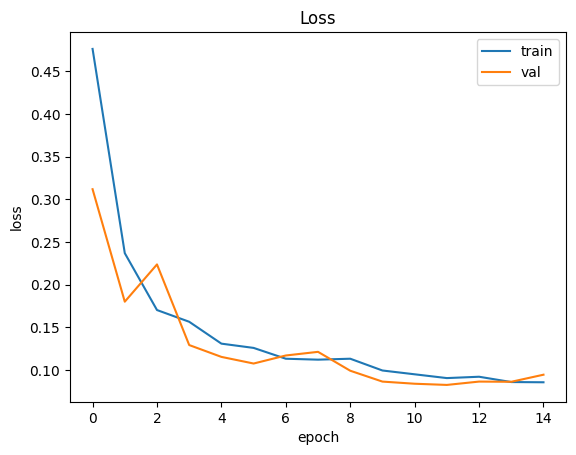

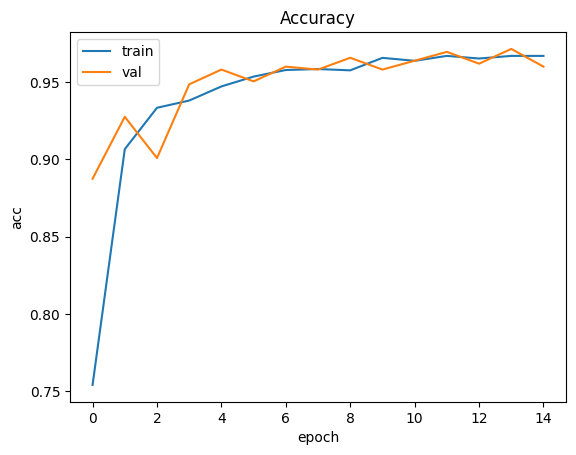

              precision    recall  f1-score   support

           0     0.9613    0.6368    0.7661       234
           1     0.8188    0.9846    0.8941       390

    accuracy                         0.8542       624
   macro avg     0.8900    0.8107    0.8301       624
weighted avg     0.8722    0.8542    0.8461       624



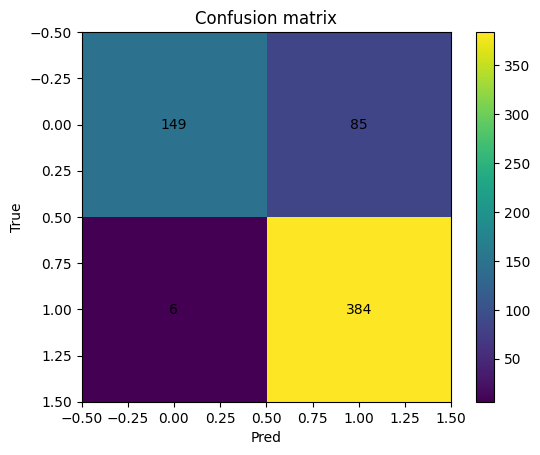

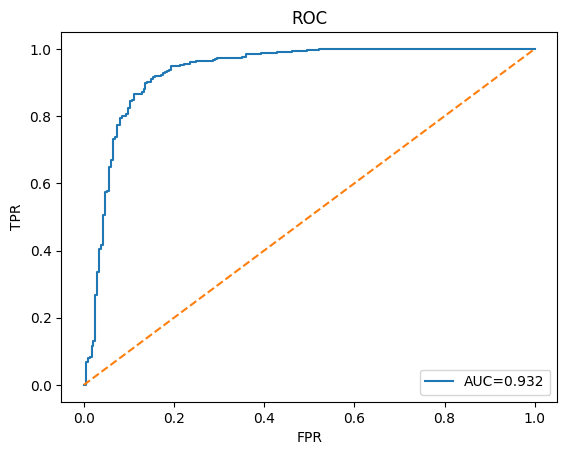

FailedPreconditionError: cnn_pneumonia_savedmodel\variables is not a directory

In [15]:
# Model
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

IMG=64; CH=1
model = models.Sequential([
    layers.Input(shape=(IMG,IMG,CH)),
    layers.Conv2D(16, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint("cnn_pneu.h5", monitor="val_loss", save_best_only=True)

# Trening
EPOCHS=15
hist = model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=[es, ckpt])

# Test
test_metrics = model.evaluate(test, verbose=0)
print({"loss":round(test_metrics[0],4), "acc":round(test_metrics[1],4), "auc":round(test_metrics[2],4)})

# Wykresy
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"]); plt.plot(hist.history["val_loss"]); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(["train","val"]); plt.show()
plt.plot(hist.history["accuracy"]); plt.plot(hist.history["val_accuracy"]); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(["train","val"]); plt.show()

# Predykcje na teście
import numpy as np
y_true = np.concatenate([y.numpy() for _,y in test])
y_prob = model.predict(test, verbose=0).ravel()
y_pred = (y_prob>=0.5).astype(int)

# Metryki i wykresy klasyfikacji
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm); plt.title("Confusion matrix"); plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

